# Dogs vs. Cats

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())





[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14161251008893255500
]


In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Cannot retrieve auth tokens.
Failure("Unexpected error response: {\n  \"error\" : \"invalid_grant\",\n  \"error_description\" : \"Code was already redeemed.\"\n}")


In [2]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [3]:
!pip install kaggle-cli

    100% |████████████████████████████████| 81kB 2.7MB/s 
    100% |████████████████████████████████| 5.3MB 250kB/s 
    100% |████████████████████████████████| 81kB 10.0MB/s 
    100% |████████████████████████████████| 102kB 10.1MB/s 
  Running setup.py bdist_wheel for kaggle-cli ... done
  Stored in directory: /content/.cache/pip/wheels/f0/3c/ff/c98870eeb0ca26250ce6a60dc9be23f547b7ef68b3d6a1c0b5
  Running setup.py bdist_wheel for cliff ... done
  Stored in directory: /content/.cache/pip/wheels/27/4c/aa/0f67aa384e67aacc5629321b1a3f85892362d4e9e5cd3a20f1
  Running setup.py bdist_wheel for configparser ... done
  Stored in directory: /content/.cache/pip/wheels/1c/bd/b4/277af3f6c40645661b4cd1c21df26aca0f2e1e9714a1d4cda8
  Running setup.py bdist_wheel for PrettyTable ... done
  Stored in directory: /content/.cache/pip/wheels/b6/90/7b/1c22b89217d0eba6d5f406e562365ebee804f0d4595b2bdbcd
  Running setup.py bdist_wheel for cmd2 ... done
  Stored in directory: /content/.cache/pip/wheels/53/53/3

In [5]:
!kg download -u ********* -p ****** -c dogs-vs-cats-redux-kernels-edition

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip

test.zip 100% |#####################################| Time: 0:00:08  33.0 MiB/s

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip

train.zip 100% |####################################| Time: 0:00:14  37.3 MiB/s

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/sample_submission.csv

sample_submission.csv 100% |########################| Time: 0:00:01  57.6 KiB/s



In [0]:
from zipfile import ZipFile
z=ZipFile("train.zip")
z.extractall()

In [17]:
!ls

datalab  sample_submission.csv	test  test.zip	train  train.zip


https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [19]:
import numpy as np
!pip install keras
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

    100% |████████████████████████████████| 327kB 2.3MB/s 


Using TensorFlow backend.


In [0]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [0]:
import re
from random import shuffle
from glob import glob

train_files = glob('./train/*.jpg')
test_files = glob('./test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

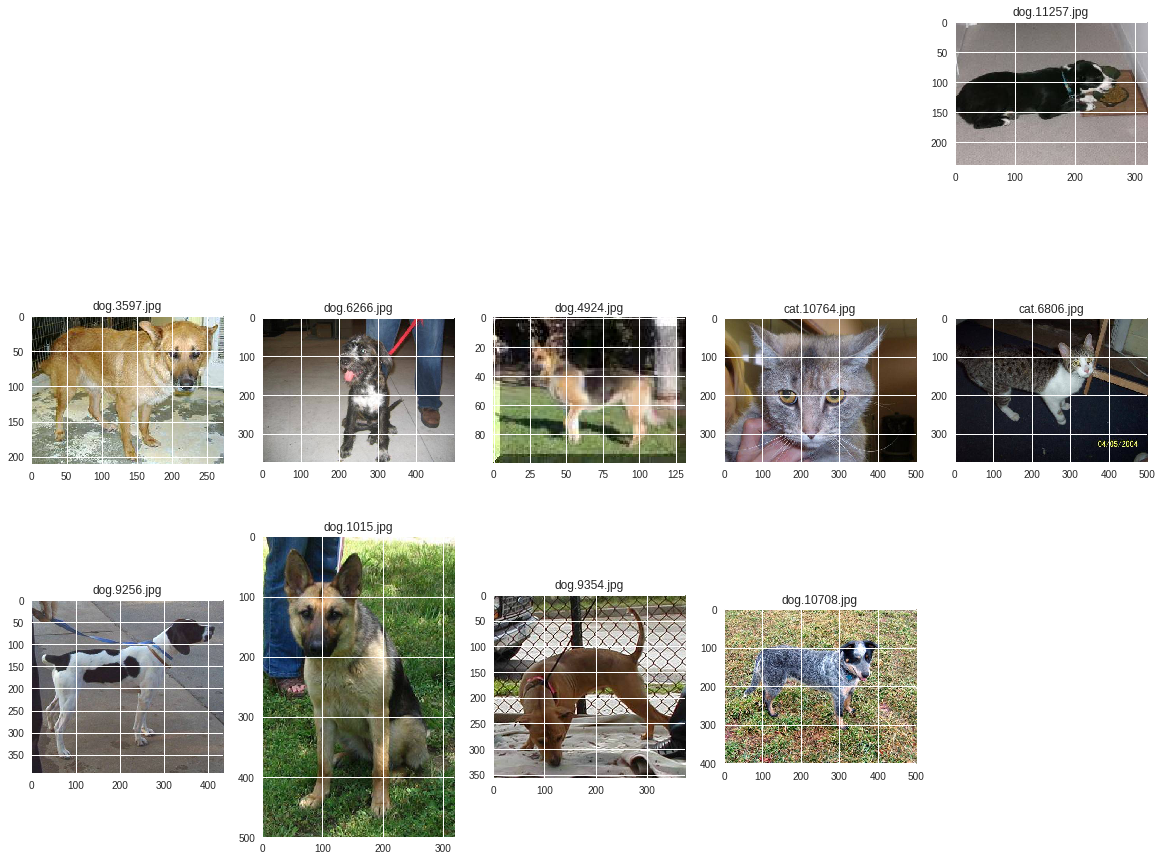

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [23]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

94658560/94653016 [==============================] - 1s 0us/step


In [0]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [25]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Добавляем полносвязный слой

In [0]:
x = base_model.layers[-5].output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Компилируем модель и запускаем обучение

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [0]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

In [30]:
validation_data

(array([[[[-6.5939003e+01, -5.9778999e+01, -3.1680000e+01],
          [-9.6939003e+01, -9.0778999e+01, -6.2680000e+01],
          [-9.3939003e+01, -8.7778999e+01, -5.9680000e+01],
          ...,
          [-8.9939003e+01, -1.0277900e+02, -9.7680000e+01],
          [-9.8939003e+01, -1.0277900e+02, -9.9680000e+01],
          [-9.8939003e+01, -1.0277900e+02, -9.9680000e+01]],
 
         [[-6.6939003e+01, -6.0778999e+01, -3.4680000e+01],
          [-9.7939003e+01, -9.1778999e+01, -6.5680000e+01],
          [-8.8939003e+01, -8.2778999e+01, -5.6680000e+01],
          ...,
          [-9.1939003e+01, -1.0477900e+02, -9.9680000e+01],
          [-9.6939003e+01, -1.0377900e+02, -9.9680000e+01],
          [-9.6939003e+01, -1.0377900e+02, -9.9680000e+01]],
 
         [[-7.0939003e+01, -6.5778999e+01, -4.3680000e+01],
          [-9.8939003e+01, -9.3778999e+01, -7.1680000e+01],
          [-8.3939003e+01, -7.8778999e+01, -5.6680000e+01],
          ...,
          [-9.3939003e+01, -1.0677900e+02, -1.016

In [31]:
# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=10,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 6s 563ms/step - loss: 0.6954 - acc: 0.6844 - val_loss: 0.2214 - val_acc: 0.9400
Epoch 2/10
10/10 [==============================] - 4s 379ms/step - loss: 0.2237 - acc: 0.9344 - val_loss: 0.1794 - val_acc: 0.9400
Epoch 3/10
10/10 [==============================] - 4s 384ms/step - loss: 0.1785 - acc: 0.9406 - val_loss: 0.2684 - val_acc: 0.9300
Epoch 4/10
10/10 [==============================] - 4s 385ms/step - loss: 0.1807 - acc: 0.9563 - val_loss: 0.1981 - val_acc: 0.9400
Epoch 5/10
10/10 [==============================] - 4s 383ms/step - loss: 0.2424 - acc: 0.9437 - val_loss: 0.2261 - val_acc: 0.9500
Epoch 6/10
10/10 [==============================] - 4s 384ms/step - loss: 0.2350 - acc: 0.9344 - val_loss: 0.1878 - val_acc: 0.9400
Epoch 7/10
10/10 [==============================] - 4s 384ms/step - loss: 0.1437 - acc: 0.9594 - val_loss: 0.1742 - val_acc: 0.9400
Epoch 8/10
10/10 [==============================] - 4s 382ms/step - loss: 0.

In [0]:
model.save('new_model')

## Предсказания на проверочной выборке

In [0]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

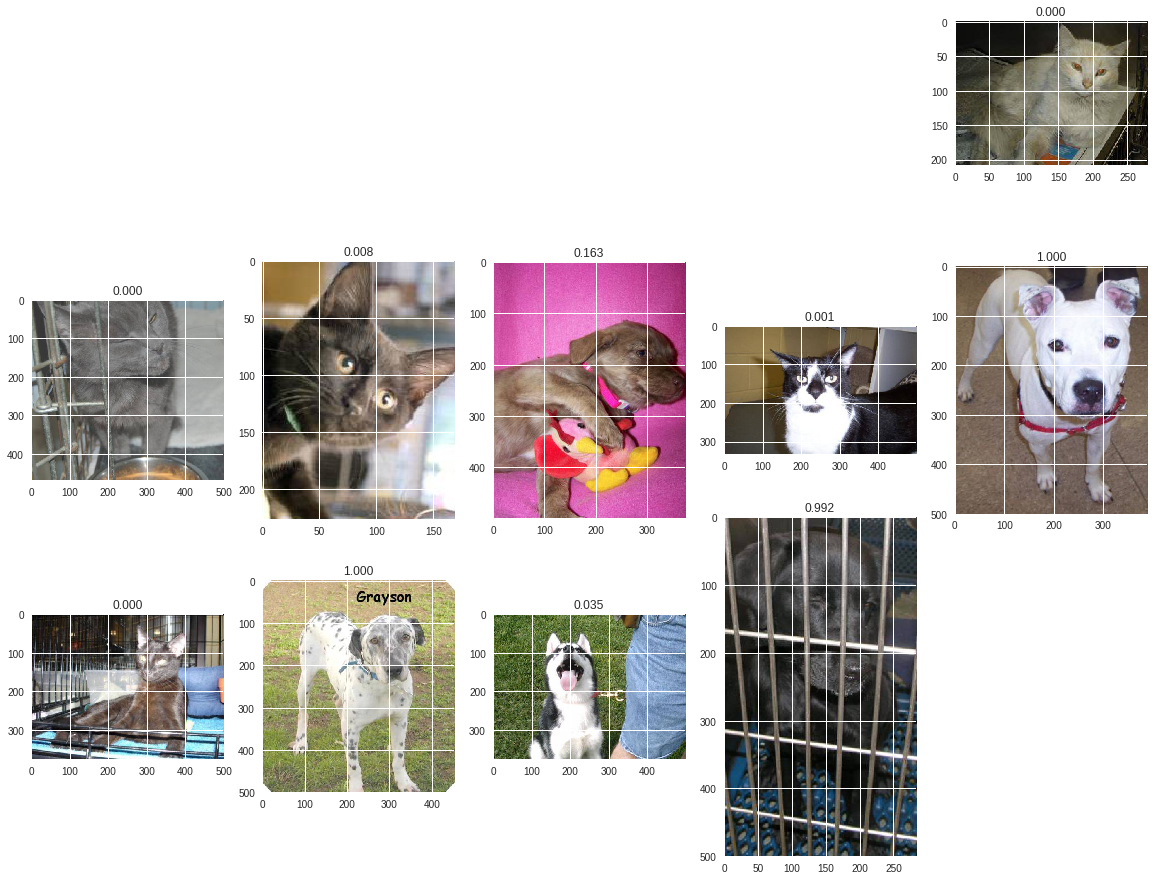

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [0]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [0]:
# LogLoss = 0.11941

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [0]:
!cp submit.txt drive/app2/submit.txt

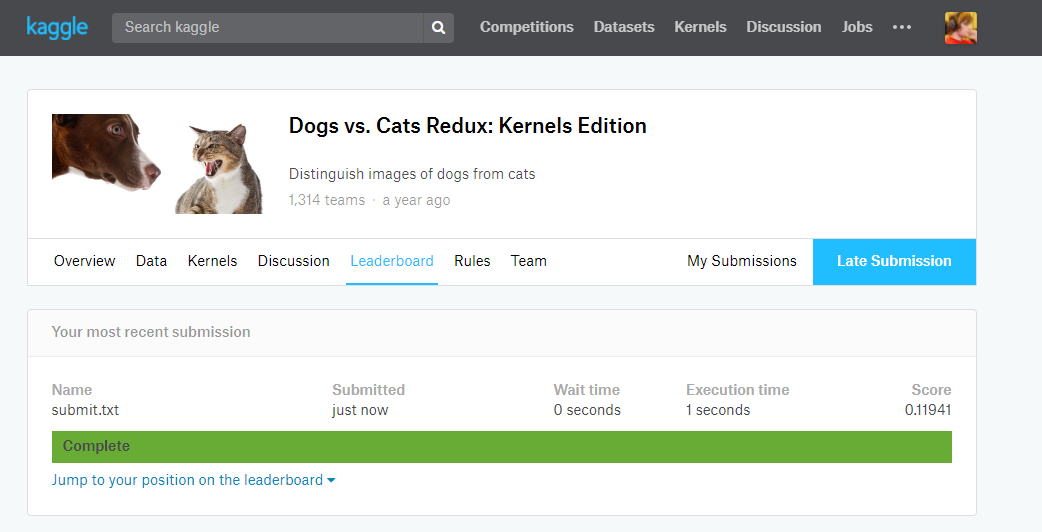

In [1]:
from IPython.display import Image
Image(filename='kaggle.PNG')